# Finite elements analysis  in 2D

### Problem:
Solve Laplace equation 
$$
\frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2} = 0
$$
in the rectangle where $U$ at the boundaries is known.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,9)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cols = np.array([[0,63,191],[0,127,159],[127,191,127],[255,255,95],[223,127,63],[191,0,31],[159,0,0]])/255
cmap2 = LinearSegmentedColormap.from_list('test',cols, 1+6*25)

In [4]:
# meshing from Matlab
nodes = np.round(np.loadtxt('nodes.txt',delimiter=','),3)/2+1/2 #from (-1,1) to (0,1)
cells = np.loadtxt('cells.txt',delimiter=',').astype(int)-1 # in matlab indices start from 1

In [5]:
x = nodes[:, 0]
y = nodes[:, 1]

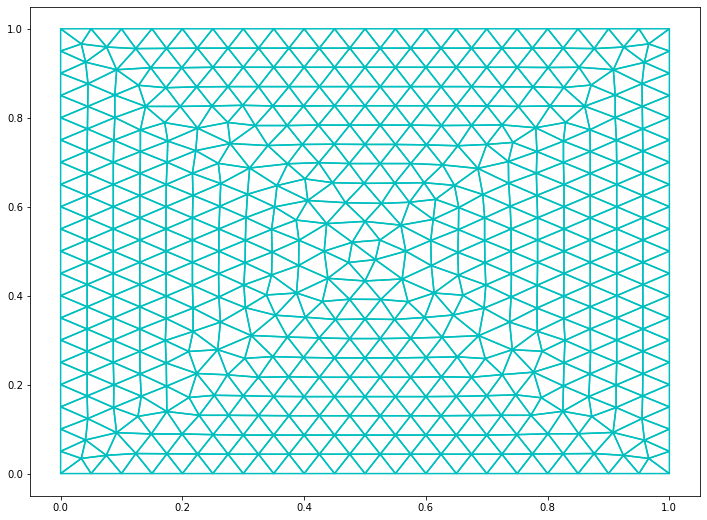

In [6]:
for ind in range(len(cells)):
    cell = np.r_[cells[ind, :], cells[ind, 0]]
    x = nodes[cell, 0]
    y = nodes[cell, 1]
    plt.plot(x, y, 'c')
    # cell indices
    # plt.text(x[:3].mean(), y[:3].mean(), ind, fontsize=6,va='center',ha='center')
for ind in range(len(nodes)):
    node = nodes[ind, :]
    # nodes indices
    # plt.text(node[0], node[1], ind, va='center', ha='center',fontsize=8, color='red')

In [7]:
# there are 80 nodes on the boundary
values = [0]*80 + [None]*(len(nodes)-80)
len(values), len(nodes)

(494, 494)

In [8]:
B = np.array(values, dtype=np.float)
## defining boundaries
B[23:42] = np.sin(2*np.pi*np.linspace(0,1,19))
B[61:80] = np.sin(3*np.pi*np.linspace(0,1,19))
B[4:23] = np.sin(np.pi*np.linspace(0,1,19))
x = np.linspace(0,1,21)[1:-1]
B[42:61] = -4*x*(1-x)

In [9]:
N = len(nodes)
A = np.zeros((N,N))

In [10]:
L = len(cells)
for j in range(L):
    cell = cells[j, :]
    node = nodes[cell]
    x1 = node[0,0]
    x2 = node[1,0]
    x3 = node[2,0]
    y1 = node[0,1]
    y2 = node[1,1]
    y3 = node[2,1]
    D = np.array([[x1-x2,x2-x3,x3-x1],[y1-y2,y2-y3,y3-y1]])
    S = (x1*y2 + x2*y3 + x3*y1 - x1*y3 - x2*y1 - x3*y2) # 2x area of the cell 
    ST = D.T @ D / 2 /S # Stiffness matrix
    A[cell[:, None], cell[None, :]] += ST # beware of 2d indexing in numpy. A[cell, cell] does not work.

In [35]:
ind = ~np.isnan(B)
a = A[ind][:, ind]
b = B[ind]

In [37]:
xx = np.linalg.solve(a, b)
BB = A[~ind][:, ind] @ xx
AA = A[~ind][:, ~ind]
S = np.linalg.solve(AA, -BB)
B[~ind] = S

## Visualization

### Values in the nodes

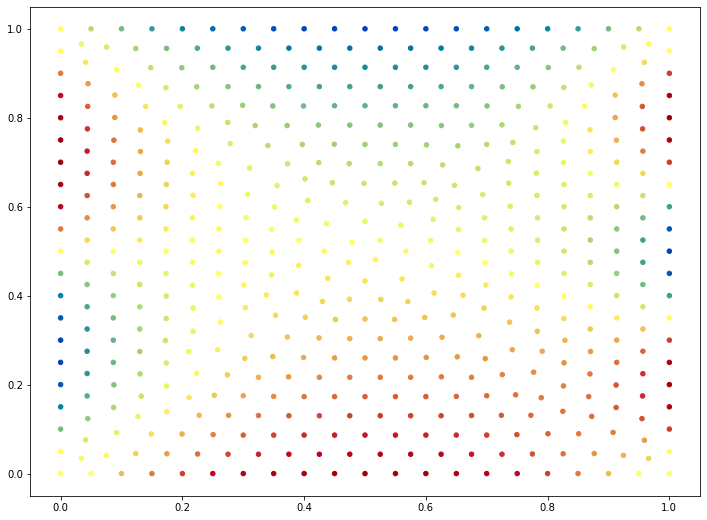

In [18]:
plt.scatter(nodes[:, 0], nodes[:, 1], c=B, s=20, cmap=cmap2)#'Spectral_r')

### Triangles based on average color within the cell

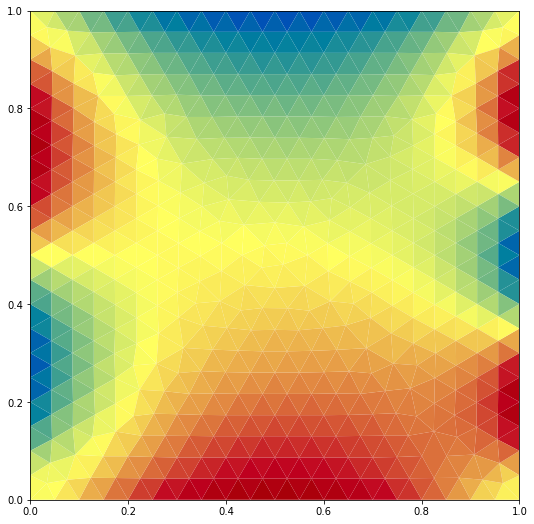

In [39]:
from matplotlib.patches import Polygon
from matplotlib.pyplot import get_cmap
cols = cmap2#get_cmap('Spectral_r')
#plt.scatter(nodes[:, 0], nodes[:, 1], c=B, s=20, cmap='Spectral_r')
Bm = B.min()
B_ = B.max()-B.min()
for i in range(L):
    cell = cells[i, :]
    pts = nodes[cell, :]
    c = (B[cell].mean()-Bm)/B_
    poly = Polygon(pts,facecolor=cols(c),edgecolor='none')
    plt.gca().add_patch(poly)
plt.gca().set_aspect(1)

### Overlapping scatter plot, color each point is interpolated within the cell

In [41]:
# for each triangle N*N/2 points are calculated
N = 10 
X = []
Y = []
C = []
for i in range(L):
    cell = cells[i, :]
    pts = nodes[cell, :]
    x0 = pts[0, 0]
    y0 = pts[0, 1]
    dx1 = pts[1, 0] - x0
    dx2 = pts[2, 0] - x0
    dy1 = pts[1, 1] - y0
    dy2 = pts[2, 1] - y0
    v0 = B[cell[0]]
    v1 = B[cell[1]] - v0
    v2 = B[cell[2]] - v0
    for j in range(0, N):
        for k in range(N-j):
            X.append(x0+j*dx1/N+k*dx2/N)
            Y.append(y0+j*dy1/N+k*dy2/N)
            C.append(v0+j*v1/N+k*v2/N)

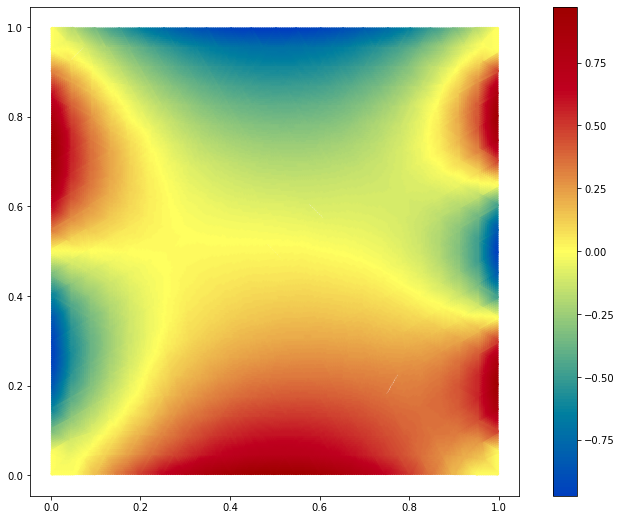

In [43]:
#plt.scatter(nodes[:, 0], nodes[:, 1], c=B, s=20, cmap=cmap2)#'Spectral_r')
plt.scatter(X,Y,c=C,s=8, cmap=cmap2)#'Spectral_r')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.gca().set_aspect(1)
plt.colorbar()

### 2D image where every value is detetmined from the closest oint of the affine grid

In [45]:
# fill rectanglular grid with intermediate points
# 1) make a affine grid within each triangle
# 2) for each point of the triangular grid find the closest point in rectangular
# 3) assign the value
x = np.linspace(0,1,81)
dx = (x[1]-x[0])/2
y = np.linspace(0,1,51)
G = np.zeros((len(y), len(x)))
dy = (y[1]-y[0])/2
G[:] = np.nan
N = 15
for i in range(L):
    cell = cells[i, :]
    pts = nodes[cell, :]
    x0 = pts[0, 0]
    y0 = pts[0, 1]
    dx1 = pts[1, 0] - x0
    dx2 = pts[2, 0] - x0
    dy1 = pts[1, 1] - y0
    dy2 = pts[2, 1] - y0
    v0 = B[cell[0]]
    v1 = B[cell[1]] - v0
    v2 = B[cell[2]] - v0
    for j in range(0, N):
        for k in range(N+1-j):
            x_ = x0+j*dx1/N+k*dx2/N
            y_ = y0+j*dy1/N+k*dy2/N
            ix = np.argmin(np.abs(x_ - x))
            iy = np.argmin(np.abs(y_ - y))
            if np.isnan(G[iy, ix]):
                G[iy, ix] = v0+j*v1/N+k*v2/N

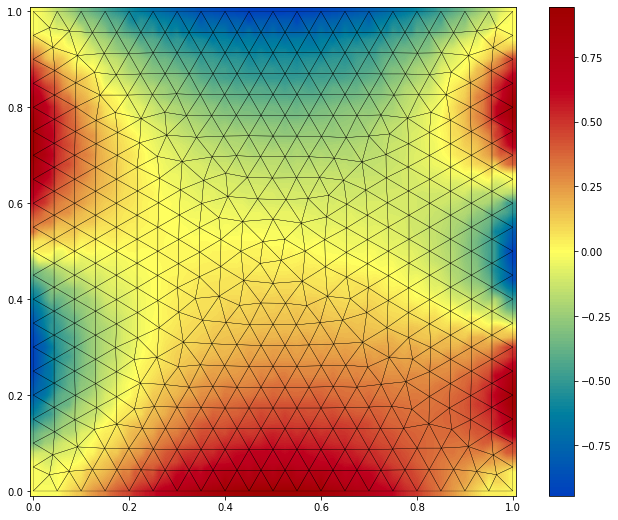

In [46]:
plt.imshow(G,cmap=cmap2,origin='lower',
           extent=(x.min()-dx,x.max()+dx, y.min()-dy,y.max()+dy), interpolation='bilinear')
for ind in range(len(cells)):
    cell = np.r_[cells[ind, :], cells[ind, 0]]
    #cell = cells[ind,:]
    x_ = nodes[cell, 0]
    y_ = nodes[cell, 1]
    plt.plot(x_, y_, 'k',linewidth=0.25)
plt.colorbar()

In [27]:
def stiffness(coords):
    '''
    Returns stiffness matrix for tthe triangle given by its coordinates
    : coords : 6 values
    '''
    x1, y1, x2, y2, x3,  y3 = list(coords)
    D = np.array([[x1-x2,x2-x3,x3-x1],[y1-y2,y2-y3,y3-y1]])
    S = (x1*y2 + x2*y3 + x3*y1 - x1*y3 - x2*y1 - x3*y2) # 2x area of the cell 
    ST = D.T @ D / 2 /S # Stiffness matrix
    plt.plot([x1,x2,x3,x1],[y1,y2,y3,y1])
    plt.gca().set_aspect(1)
    return ST

array([[ 0.5, -0.5,  0. ],
       [-0.5,  1. , -0.5],
       [ 0. , -0.5,  0.5]])

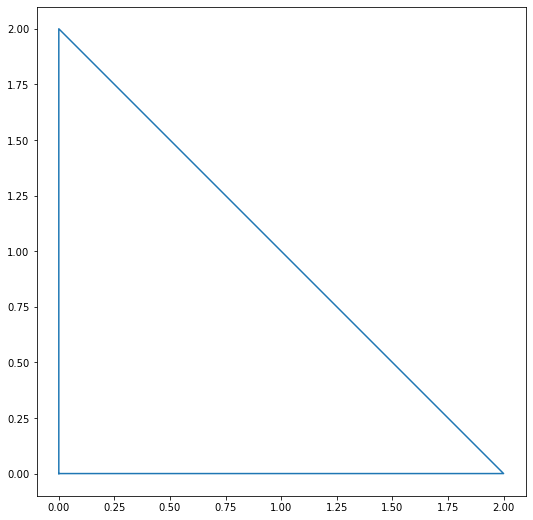

In [28]:
stiffness([0,0,2,0,0, 2])

array([[-0.57735027,  0.28867513,  0.28867513],
       [ 0.28867513, -0.57735027,  0.28867513],
       [ 0.28867513,  0.28867513, -0.57735027]])

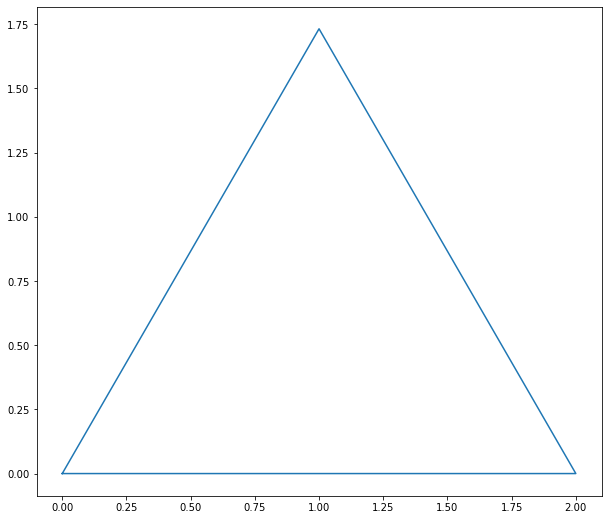

In [29]:
s = stiffness([0,0,1, 3**0.5,2,0])
s